In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.autograd import Variable

from tqdm.notebook import tqdm

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR

#### Use the MNIST dataset for all the experiments.

In [2]:
dataset = MNIST('data', train=True, download=True, transform=ToTensor())
test_dataset = MNIST('data', train=False, transform=ToTensor())

#### Use a 70:30 data split.

In [3]:
train_size = int(len(dataset) * 0.70)
val_size = len(dataset) - train_size

In [4]:
train_ds, val_ds = random_split(dataset, [train_size, val_size])

In [5]:
batch_size=128

train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)
test_loader = DataLoader(test_dataset, batch_size)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

### Evaluation Method

In [7]:
def evaluate(model, data_lodr, weights_path="q2.pth"):
    
    # prework
    model.to(device)
    model.load_state_dict(torch.load(weights_path))

    #evaluation
    correct = 0
    total = 0
    
    for data in data_lodr:
        images, labels = Variable(data[0].view(-1, 28 * 28)).to(device), Variable(data[1]).to(device)
        
        with torch.no_grad():
            outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return (100 * correct / total)

### Training method

In [8]:
def train(model, optimizer, train_lodr, val_lodr, epochs=20, weights_path="q2.pth", transfer_learning=False, save_weights=True, decay=False, schedular=None):

    # Prework
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    if transfer_learning == True:
        model.load_state_dict(torch.load(weights_path))

    # Training
    # print("Trainning Started...")

    train_loss = []
    val_loss = []

    lrs = []

    for epoch in tqdm(range(epochs)):

        # print("Epoch["+str(epoch)+"]:")

        # Training work
        train_running_loss = 0.0
        for i, data in enumerate(train_lodr, 0):
            
            inputs, labels = Variable(data[0].view(-1, 28 * 28)).to(device), Variable(data[1]).to(device)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()
        
        train_loss.append(train_running_loss/ len(train_lodr))

        # Validation work
        val_running_loss = 0.0
        for i, data in enumerate(val_lodr, 0):
            
            inputs, labels = Variable(data[0].view(-1, 28 * 28)).to(device), Variable(data[1]).to(device)

            with torch.no_grad():
                outputs = model(inputs)   
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
        
        val_loss.append(val_running_loss/ len(val_lodr))

        # print("\tTrain-Loss: "+str(train_loss[-1]))
        # print("\tVal-Loss:   "+str(val_loss[-1]))

        if decay == True:
            schedular.step()
            lrs.append(optimizer.param_groups[0]['lr'])

    # print("Trainning Ended...")

    # post Work
    if save_weights == True:
        torch.save(model.state_dict(), weights_path)

    return train_loss, val_loss, lrs

### Plot

In [9]:
epochs = 20
def plotlossgraph(x, y1, y2, title='Q1'):
    plt.plot(x, y1, 'g', label='Training loss')
    plt.plot(x, y2, 'b', label='validation loss')

    plt.title(title+' Training and Validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.legend()
    plt.show()

xepoch = range(1,epochs+1)

# Part 1

# Question 
## Normal Weight Initialization

In [10]:
class Q64Net(nn.Module):
    def __init__(self):
        super(Q64Net, self).__init__()

        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

        self.relu = nn.ReLU()
        
        nn.init.normal_(self.fc1.weight)
        nn.init.normal_(self.fc2.weight)
        nn.init.normal_(self.fc3.weight)

    def forward(self, x):
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

q64net = Q64Net()
q64net


Q64Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

### Adam

In [11]:
q64net = Q64Net()
q64_adam_optimizer = optim.Adam(q64net.parameters(), lr=0.001)

q64_adam_train_loss, q64_adam_val_loss, _ = train(q64net, q64_adam_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_Normal_adam.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [12]:
q64_adam_accu = evaluate(q64net, test_loader, weights_path="q2_Normal_adam.pth")
q64_adam_accu

91.97

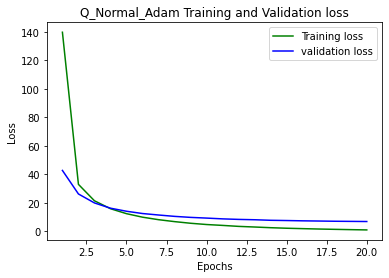

In [13]:
plotlossgraph(xepoch, q64_adam_train_loss, q64_adam_val_loss, title='Q_Normal_Adam')

### RMSProp

In [14]:
q64net = Q64Net()
q64_RMSProp_optimizer = optim.RMSprop(q64net.parameters(), lr=0.001, alpha=0.9)

q64_RMSProp_train_loss, q64_RMSProp_val_loss, _ = train(q64net, q64_RMSProp_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_Normal_RMSProp.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [15]:
q64_RMSProp_accu = evaluate(q64net, test_loader, weights_path="q2_Normal_RMSProp.pth")
q64_RMSProp_accu

92.13

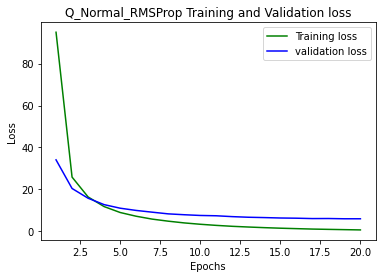

In [16]:
plotlossgraph(xepoch, q64_RMSProp_train_loss, q64_RMSProp_val_loss, title='Q_Normal_RMSProp')

### SGD with momentom

In [17]:
q64net = Q64Net()
q64_SGD_optimizer = optim.SGD(q64net.parameters(), lr=0.001, momentum=0.9)

q64_SGD_train_loss, q64_SGD_val_loss, _ = train(q64net, q64_SGD_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_Normal_SGD.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [18]:
q64_SGD_accu = evaluate(q64net, test_loader, weights_path="q2_Normal_SGD.pth")
q64_SGD_accu

83.74

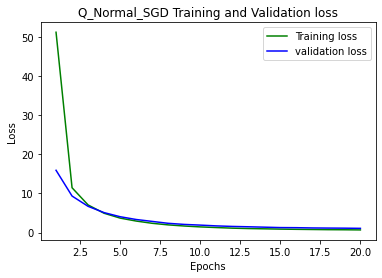

In [19]:
plotlossgraph(xepoch, q64_SGD_train_loss, q64_SGD_val_loss, title='Q_Normal_SGD')

### SGD Without momentom

In [20]:
q64net = Q64Net()
q64_SGD2_optimizer = optim.SGD(q64net.parameters(), lr=0.001)

q64_SGD2_train_loss, q64_SGD2_val_loss, _ = train(q64net, q64_SGD2_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_Normal_SGD2.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [21]:
q64_SGD2_accu = evaluate(q64net, test_loader, weights_path="q2_Normal_SGD2.pth")
q64_SGD2_accu

86.91

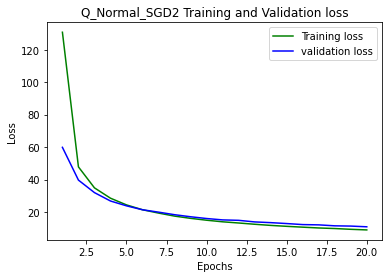

In [22]:
plotlossgraph(xepoch, q64_SGD2_train_loss, q64_SGD2_val_loss, title='Q_Normal_SGD2')

### Try different learning rates and also perform exponential annealing on the learning rate.

In [23]:
q64net = Q64Net()
q64_SGD_optimizer = optim.SGD(q64net.parameters(), lr=0.001, momentum=0.9)
q64_schedular = ExponentialLR(q64_SGD_optimizer, gamma=0.999)

q64_SGD_train_loss, q64_SGD_val_loss, lrs = train(q64net, q64_SGD_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_Normal_SGD.pth", transfer_learning=False, save_weights=True, decay=True, schedular=q64_schedular)

  0%|          | 0/20 [00:00<?, ?it/s]

In [24]:
lrs

[0.000999,
 0.000998001,
 0.000997002999,
 0.000996005996001,
 0.000995009990004999,
 0.000994014980014994,
 0.0009930209650349789,
 0.0009920279440699439,
 0.0009910359161258739,
 0.000990044880209748,
 0.0009890548353295382,
 0.0009880657804942088,
 0.0009870777147137145,
 0.0009860906369990009,
 0.000985104546362002,
 0.00098411944181564,
 0.0009831353223738242,
 0.0009821521870514505,
 0.000981170034864399,
 0.0009801888648295347]

In [25]:
q64_SGD_accu = evaluate(q64net, test_loader, weights_path="q2_Normal_SGD.pth")
q64_SGD_accu

88.45

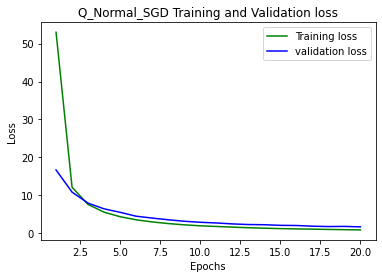

In [26]:
plotlossgraph(xepoch, q64_SGD_train_loss, q64_SGD_val_loss, title='Q_Normal_SGD')

# Question 
## Uniform Weight Initialization

In [27]:
class Q32Net(nn.Module):
    def __init__(self):
        super(Q32Net, self).__init__()

        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

        self.relu = nn.ReLU()
        
        nn.init.uniform_(self.fc1.weight)
        nn.init.uniform_(self.fc2.weight)
        nn.init.uniform_(self.fc3.weight)

    def forward(self, x):
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

q32net = Q32Net()
q32net


Q32Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

### Adam

In [28]:
q32net = Q32Net()
q32_adam_optimizer = optim.Adam(q32net.parameters(), lr=0.001)

q32_adam_train_loss, q32_adam_val_loss, _ = train(q32net, q32_adam_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_Uniform_adam.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [29]:
q32_adam_accu = evaluate(q32net, test_loader, weights_path="q2_Uniform_adam.pth")
q32_adam_accu

85.39

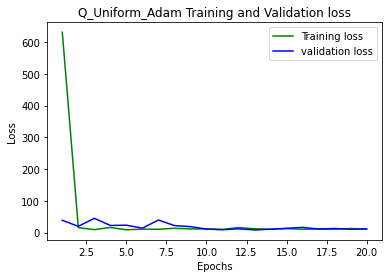

In [30]:
plotlossgraph(xepoch, q32_adam_train_loss, q32_adam_val_loss, title='Q_Uniform_Adam')

### RMSProp

In [31]:
q32net = Q32Net()
q32_RMSProp_optimizer = optim.RMSprop(q32net.parameters(), lr=0.001, alpha=0.9)

q32_RMSProp_train_loss, q32_RMSProp_val_loss, _ = train(q32net, q32_RMSProp_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_Uniform_RMSProp.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [32]:
q32_RMSProp_accu = evaluate(q32net, test_loader, weights_path="q2_Uniform_RMSProp.pth")
q32_RMSProp_accu

81.73

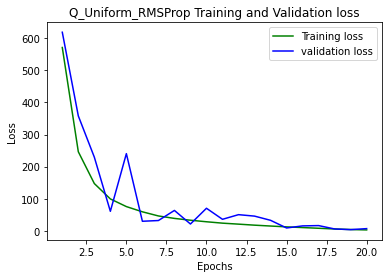

In [33]:
plotlossgraph(xepoch, q32_RMSProp_train_loss, q32_RMSProp_val_loss, title='Q_Uniform_RMSProp')

### SGD with momentom

In [34]:
q32net = Q32Net()
q32_SGD_optimizer = optim.SGD(q32net.parameters(), lr=0.001, momentum=0.9)

q32_SGD_train_loss, q32_SGD_val_loss, _ = train(q32net, q32_SGD_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_Uniform_SGD.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [35]:
q32_SGD_accu = evaluate(q32net, test_loader, weights_path="q2_Uniform_SGD.pth")
q32_SGD_accu

11.35

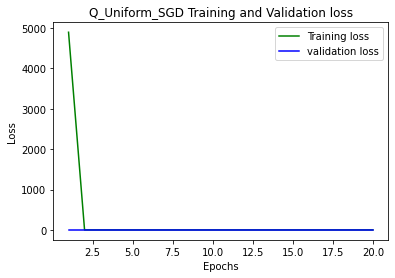

In [36]:
plotlossgraph(xepoch, q32_SGD_train_loss, q32_SGD_val_loss, title='Q_Uniform_SGD')

### SGD Without momentom

In [37]:
q32net = Q32Net()
q32_SGD2_optimizer = optim.SGD(q32net.parameters(), lr=0.001)

q32_SGD2_train_loss, q32_SGD2_val_loss, _ = train(q32net, q32_SGD2_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_Uniform_SGD2.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [38]:
q32_SGD2_accu = evaluate(q32net, test_loader, weights_path="q2_Uniform_SGD2.pth")
q32_SGD2_accu

19.4

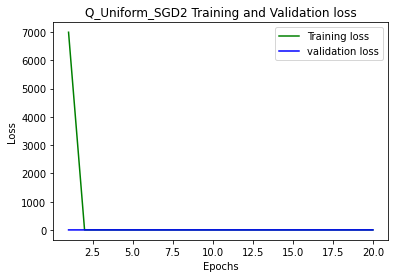

In [39]:
plotlossgraph(xepoch, q32_SGD2_train_loss, q32_SGD2_val_loss, title='Q_Uniform_SGD2')

### Try different learning rates and also perform exponential annealing on the learning rate.

In [40]:
q32net = Q32Net()
q32_RMSProp_optimizer = optim.RMSprop(q32net.parameters(), lr=0.001, alpha=0.9)
q32_schedular = ExponentialLR(q32_RMSProp_optimizer, gamma=0.999)

q32_RMSProp_train_loss, q32_RMSProp_val_loss, lrs = train(q32net, q32_RMSProp_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_Uniform_RMSProp.pth", transfer_learning=False, save_weights=True, decay=True, schedular=q32_schedular)

  0%|          | 0/20 [00:00<?, ?it/s]

In [41]:
lrs

[0.000999,
 0.000998001,
 0.000997002999,
 0.000996005996001,
 0.000995009990004999,
 0.000994014980014994,
 0.0009930209650349789,
 0.0009920279440699439,
 0.0009910359161258739,
 0.000990044880209748,
 0.0009890548353295382,
 0.0009880657804942088,
 0.0009870777147137145,
 0.0009860906369990009,
 0.000985104546362002,
 0.00098411944181564,
 0.0009831353223738242,
 0.0009821521870514505,
 0.000981170034864399,
 0.0009801888648295347]

In [42]:
q32_RMSProp_accu = evaluate(q32net, test_loader, weights_path="q2_Uniform_RMSProp.pth")
q32_RMSProp_accu

80.43

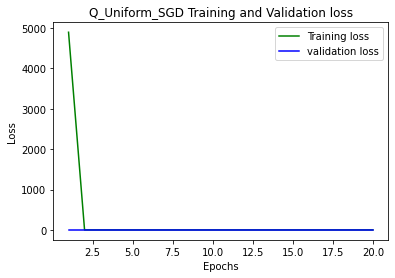

In [43]:
plotlossgraph(xepoch, q32_SGD_train_loss, q32_SGD_val_loss, title='Q_Uniform_SGD')

# Question 
## xavier Weight Initialization

In [44]:
class Q16Net(nn.Module):
    def __init__(self):
        super(Q16Net, self).__init__()

        self.fc1 = nn.Linear(784, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

        self.relu = nn.ReLU()
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

q16net = Q16Net()
q16net


Q16Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

### Adam

In [45]:
q16net = Q16Net()
q16_adam_optimizer = optim.Adam(q16net.parameters(), lr=0.001)

q16_adam_train_loss, q16_adam_val_loss, _ = train(q16net, q16_adam_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_xavier_adam.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [46]:
q16_adam_accu = evaluate(q16net, test_loader, weights_path="q2_xavier_adam.pth")
q16_adam_accu

97.6

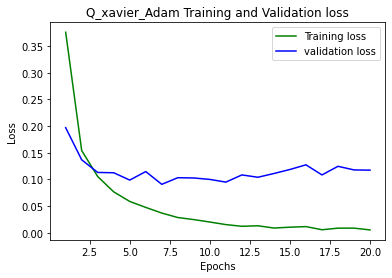

In [47]:
plotlossgraph(xepoch, q16_adam_train_loss, q16_adam_val_loss, title='Q_xavier_Adam')

### RMSProp

In [48]:
q16net = Q16Net()
q16_RMSProp_optimizer = optim.RMSprop(q16net.parameters(), lr=0.001, alpha=0.9)

q16_RMSProp_train_loss, q16_RMSProp_val_loss, _ = train(q16net, q16_RMSProp_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_xavier_RMSProp.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [49]:
q16_RMSProp_accu = evaluate(q16net, test_loader, weights_path="q2_xavier_RMSProp.pth")
q16_RMSProp_accu

97.78

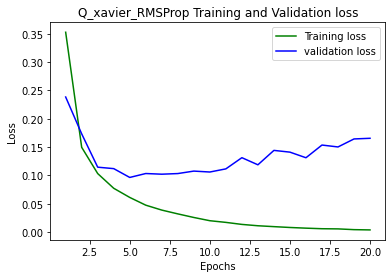

In [50]:
plotlossgraph(xepoch, q16_RMSProp_train_loss, q16_RMSProp_val_loss, title='Q_xavier_RMSProp')

### SGD with momentom

In [51]:
q16net = Q16Net()
q16_SGD_optimizer = optim.SGD(q16net.parameters(), lr=0.001, momentum=0.9)

q16_SGD_train_loss, q16_SGD_val_loss, _ = train(q16net, q16_SGD_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_xavier_SGD.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [52]:
q16_SGD_accu = evaluate(q16net, test_loader, weights_path="q2_xavier_SGD.pth")
q16_SGD_accu

93.98

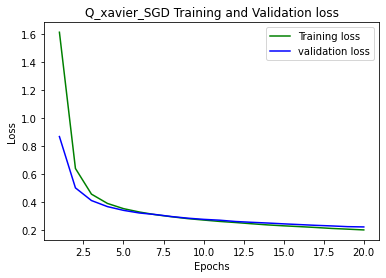

In [53]:
plotlossgraph(xepoch, q16_SGD_train_loss, q16_SGD_val_loss, title='Q_xavier_SGD')

### SGD Without momentom

In [54]:
q16net = Q16Net()
q16_SGD2_optimizer = optim.SGD(q16net.parameters(), lr=0.001)

q16_SGD2_train_loss, q16_SGD2_val_loss, _ = train(q16net, q16_SGD2_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_xavier_SGD2.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [55]:
q16_SGD2_accu = evaluate(q16net, test_loader, weights_path="q2_xavier_SGD2.pth")
q16_SGD2_accu

87.33

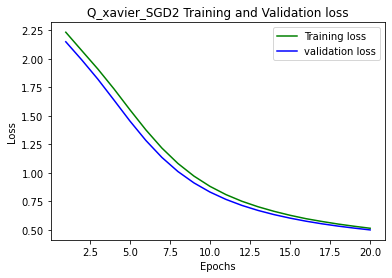

In [56]:
plotlossgraph(xepoch, q16_SGD2_train_loss, q16_SGD2_val_loss, title='Q_xavier_SGD2')

### Try different learning rates and also perform exponential annealing on the learning rate.

In [57]:
q16net = Q16Net()

q16_adam_optimizer = optim.Adam(q16net.parameters(), lr=0.001)
q16_schedular = ExponentialLR(q16_adam_optimizer, gamma=0.999)

q16_adam_train_loss, q16_adam_val_loss, lrs = train(q16net, q16_adam_optimizer, train_loader, val_loader, epochs=20, weights_path="q2_xavier_adam.pth", transfer_learning=False, save_weights=True, decay=True, schedular=q16_schedular)

  0%|          | 0/20 [00:00<?, ?it/s]

In [58]:
lrs

[0.000999,
 0.000998001,
 0.000997002999,
 0.000996005996001,
 0.000995009990004999,
 0.000994014980014994,
 0.0009930209650349789,
 0.0009920279440699439,
 0.0009910359161258739,
 0.000990044880209748,
 0.0009890548353295382,
 0.0009880657804942088,
 0.0009870777147137145,
 0.0009860906369990009,
 0.000985104546362002,
 0.00098411944181564,
 0.0009831353223738242,
 0.0009821521870514505,
 0.000981170034864399,
 0.0009801888648295347]

In [59]:
q16_adam_accu = evaluate(q16net, test_loader, weights_path="q2_xavier_adam.pth")
q16_adam_accu

97.72

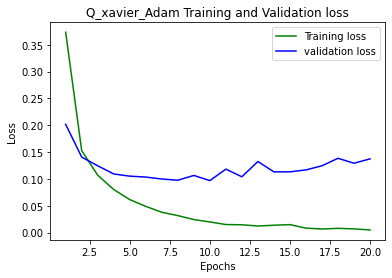

In [60]:
plotlossgraph(xepoch, q16_adam_train_loss, q16_adam_val_loss, title='Q_xavier_Adam')

# PART 2

In [61]:
def evaluate2(model, encoder, data_lodr, weights_path="q2.pth"):
    
    # prework
    model.to(device)
    model.load_state_dict(torch.load(weights_path))

    #evaluation
    correct = 0
    total = 0
    
    for data in data_lodr:
        images, labels = Variable(data[0].view(-1, 28 * 28)).to(device), Variable(data[1]).to(device)
        
        with torch.no_grad():
            encode_outputs = encoder(images, action="encode")

        with torch.no_grad():
            outputs = model(encode_outputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return (100 * correct / total)

In [62]:
def train2(model, encoder, optimizer, train_lodr, val_lodr, epochs=20, weights_path="q2.pth", transfer_learning=False, save_weights=True, decay=False, schedular=None):

    # Prework
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)

    if transfer_learning == True:
        model.load_state_dict(torch.load(weights_path))

    # Training
    # print("Trainning Started...")

    train_loss = []
    val_loss = []

    lrs = []

    for epoch in tqdm(range(epochs)):

        # print("Epoch["+str(epoch)+"]:")

        # Training work
        train_running_loss = 0.0
        for i, data in enumerate(train_lodr, 0):
            
            inputs, labels = Variable(data[0].view(-1, 28 * 28)).to(device), Variable(data[1]).to(device)
            
            with torch.no_grad():
                encode_outputs = encoder(inputs, action="encode")

            optimizer.zero_grad()

            outputs = model(encode_outputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_running_loss += loss.item()
        
        train_loss.append(train_running_loss/ len(train_lodr))

        # Validation work
        val_running_loss = 0.0
        for i, data in enumerate(val_lodr, 0):
            
            inputs, labels = Variable(data[0].view(-1, 28 * 28)).to(device), Variable(data[1]).to(device)

            with torch.no_grad():
                encode_outputs = encoder(inputs, action="encode")

            with torch.no_grad():
                outputs = model(encode_outputs)   
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
        
        val_loss.append(val_running_loss/ len(val_lodr))

        # print("\tTrain-Loss: "+str(train_loss[-1]))
        # print("\tVal-Loss:   "+str(val_loss[-1]))

        if decay == True:
            schedular.step()
            lrs.append(optimizer.param_groups[0]['lr'])

    # print("Trainning Ended...")

    # post Work
    if save_weights == True:
        torch.save(model.state_dict(), weights_path)

    return train_loss, val_loss, lrs

# Encoder
## Bottleneck - 128

In [63]:
class Q128Net(nn.Module):
    def __init__(self):
        super(Q128Net, self).__init__()

        self.encode = nn.Sequential(
            nn.Linear(in_features=784, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=128),
            nn.ReLU()
        )

        self.decode = nn.Sequential(
            nn.Linear(in_features=128, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=784),
            nn.ReLU()
        )

    def forward(self, x, action="all"):
        if action=="all":
            x = self.encode(x)
            x = self.decode(x)
        elif action=="encode":
            x = self.encode(x)
        elif action=="decode":
            x = self.decode(x)
        else:
            raise NotImplementedError
        return x

q128net = Q128Net()
q128net


Q128Net(
  (encode): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
  )
  (decode): Sequential(
    (0): Linear(in_features=128, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=784, bias=True)
    (3): ReLU()
  )
)

### SGD Without momentom

In [64]:
q128net.to(device)

weights_path="q2_128_SGD2.pth"
q128net.load_state_dict(torch.load(weights_path))

<All keys matched successfully>

## Network

In [65]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)

        self.relu = nn.ReLU()
        
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.xavier_uniform_(self.fc3.weight)

    def forward(self, x):
        
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        
        return x

net = Net()
net


Net(
  (fc1): Linear(in_features=128, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

In [66]:
net = Net()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

train_loss, val_loss, _ = train2(net, q128net, optimizer, train_loader, val_loader, epochs=20, weights_path="part2.pth", transfer_learning=False, save_weights=True)

  0%|          | 0/20 [00:00<?, ?it/s]

In [67]:
accu = evaluate2(net, q128net, test_loader, weights_path="part2.pth")
accu

92.84

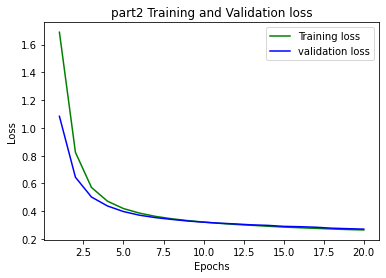

In [68]:
plotlossgraph(xepoch, train_loss, val_loss, title='part2')